# Load Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

# Define Paths to Files

In [80]:
BAD_FILE = os.path.join("C:/Users/jreye/AudioAudio/Bad/fuck1.wav") # path to single file
NOT_BAD_FILE = os.path.join("C:/Users/jreye/Documents/GoogleSpeech_V2/TRAINING_1/happy (1).wav")

SyntaxError: EOL while scanning string literal (435423134.py, line 2)

# Build Dataloading Function

In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# Plot Wave

In [4]:
wave = load_wav_16k_mono(BAD_FILE) # load data to plot wave
nwave = load_wav_16k_mono(NOT_BAD_FILE)

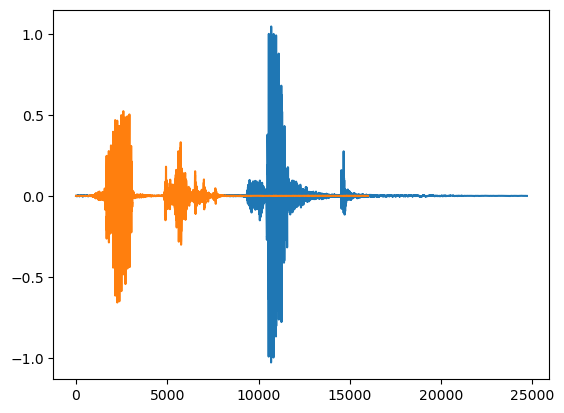

In [5]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# Create TensorFlow Dataset

In [6]:
# define paths to positive and negative data
BAD = os.path.join("C:/Users/jreye/AudioAudio/Bad") 
NOT_BAD = os.path.join("C:/Users/jreye/Documents/GoogleSpeech_V2/TRAINING_1")

In [7]:
BAD

'C:/Users/jreye/AudioAudio/Bad'

In [8]:
# create TensorFlow datasets
pos = tf.data.Dataset.list_files(BAD+'\*.wav') 
neg = tf.data.Dataset.list_files(NOT_BAD+'\*.wav')

In [9]:
pos.as_numpy_iterator().next()

b'C:\\Users\\jreye\\AudioAudio\\Bad\\Recording #26.wav'

In [10]:
# add labels and combine positive and negative samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(pos)))))
data = positives.concatenate(negatives)

In [11]:
positives.as_numpy_iterator().next()

(b'C:\\Users\\jreye\\AudioAudio\\Bad\\fuck3.wav', 1.0)

In [12]:
data.shuffle(10000).as_numpy_iterator().next()

(b'C:\\Users\\jreye\\AudioAudio\\Bad\\Recording #18.wav', 1.0)

# Determine Average Length of a Spoken Word

In [13]:
# calculate wave cycle length
lengths = []
for file in os.listdir(os.path.join("C:/Users/jreye/AudioAudio/Bad")):
    tensor_wave = load_wav_16k_mono(os.path.join("C:/Users/jreye/AudioAudio/Bad", file))
    lengths.append(len(tensor_wave))

In [14]:
# list files in bad words directory
os.listdir(os.path.join("C:/Users/jreye/AudioAudio/Bad")) 

['fuck1.wav',
 'fuck2.wav',
 'fuck3.wav',
 'fuck4.wav',
 'fuck5.wav',
 'fuck6.wav',
 'Recording #18.wav',
 'Recording #19.wav',
 'Recording #20.wav',
 'Recording #21.wav',
 'Recording #22.wav',
 'Recording #23.wav',
 'Recording #24.wav',
 'Recording #25.wav',
 'Recording #26.wav',
 'Recording #27.wav',
 'Recording #28.wav',
 'Recording #29.wav',
 'Recording #30.wav',
 'Recording #31.wav',
 'Recording #32.wav',
 'Recording #33.wav',
 'Recording #34.wav',
 'Recording #35.wav',
 'Recording #36.wav',
 'Recording #37.wav',
 'Recording #38.wav',
 'Recording #39.wav',
 'Recording #40.wav',
 'Recording #41.wav',
 'Recording #42.wav',
 'Recording #43.wav']

In [15]:
# length of each wav file
lengths

[24706,
 28049,
 29266,
 31764,
 16532,
 21548,
 13003,
 20805,
 20805,
 14303,
 14303,
 29907,
 14303,
 20805,
 24706,
 18204,
 15603,
 11702,
 15603,
 14303,
 22105,
 15603,
 14303,
 18204,
 22105,
 19504,
 22105,
 29907,
 29907,
 31207,
 22105,
 23405]

In [16]:
# calculate mean
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=20958>

In [17]:
# calculate min
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=11702>

In [18]:
# calculate max
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=31764>

In [19]:
# ave length of bad word
tf.math.reduce_mean(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=1.309875>

In [20]:
# min length of bad word
tf.math.reduce_min(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=0.731375>

In [21]:
# max length of bad word
tf.math.reduce_max(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=1.98525>

# Build Preprocessing Function to Convert to Spectrogram

In [22]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:25000] # 25000 sample length (can make smaller to reduce processing time but will affect accuracy)
    zero_padding = tf.zeros([25000] - tf.shape(wav), dtype=tf.float32) 
    wav = tf.concat([zero_padding, wav],0) # pad clips longer than 25000 samples wiht zeros
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

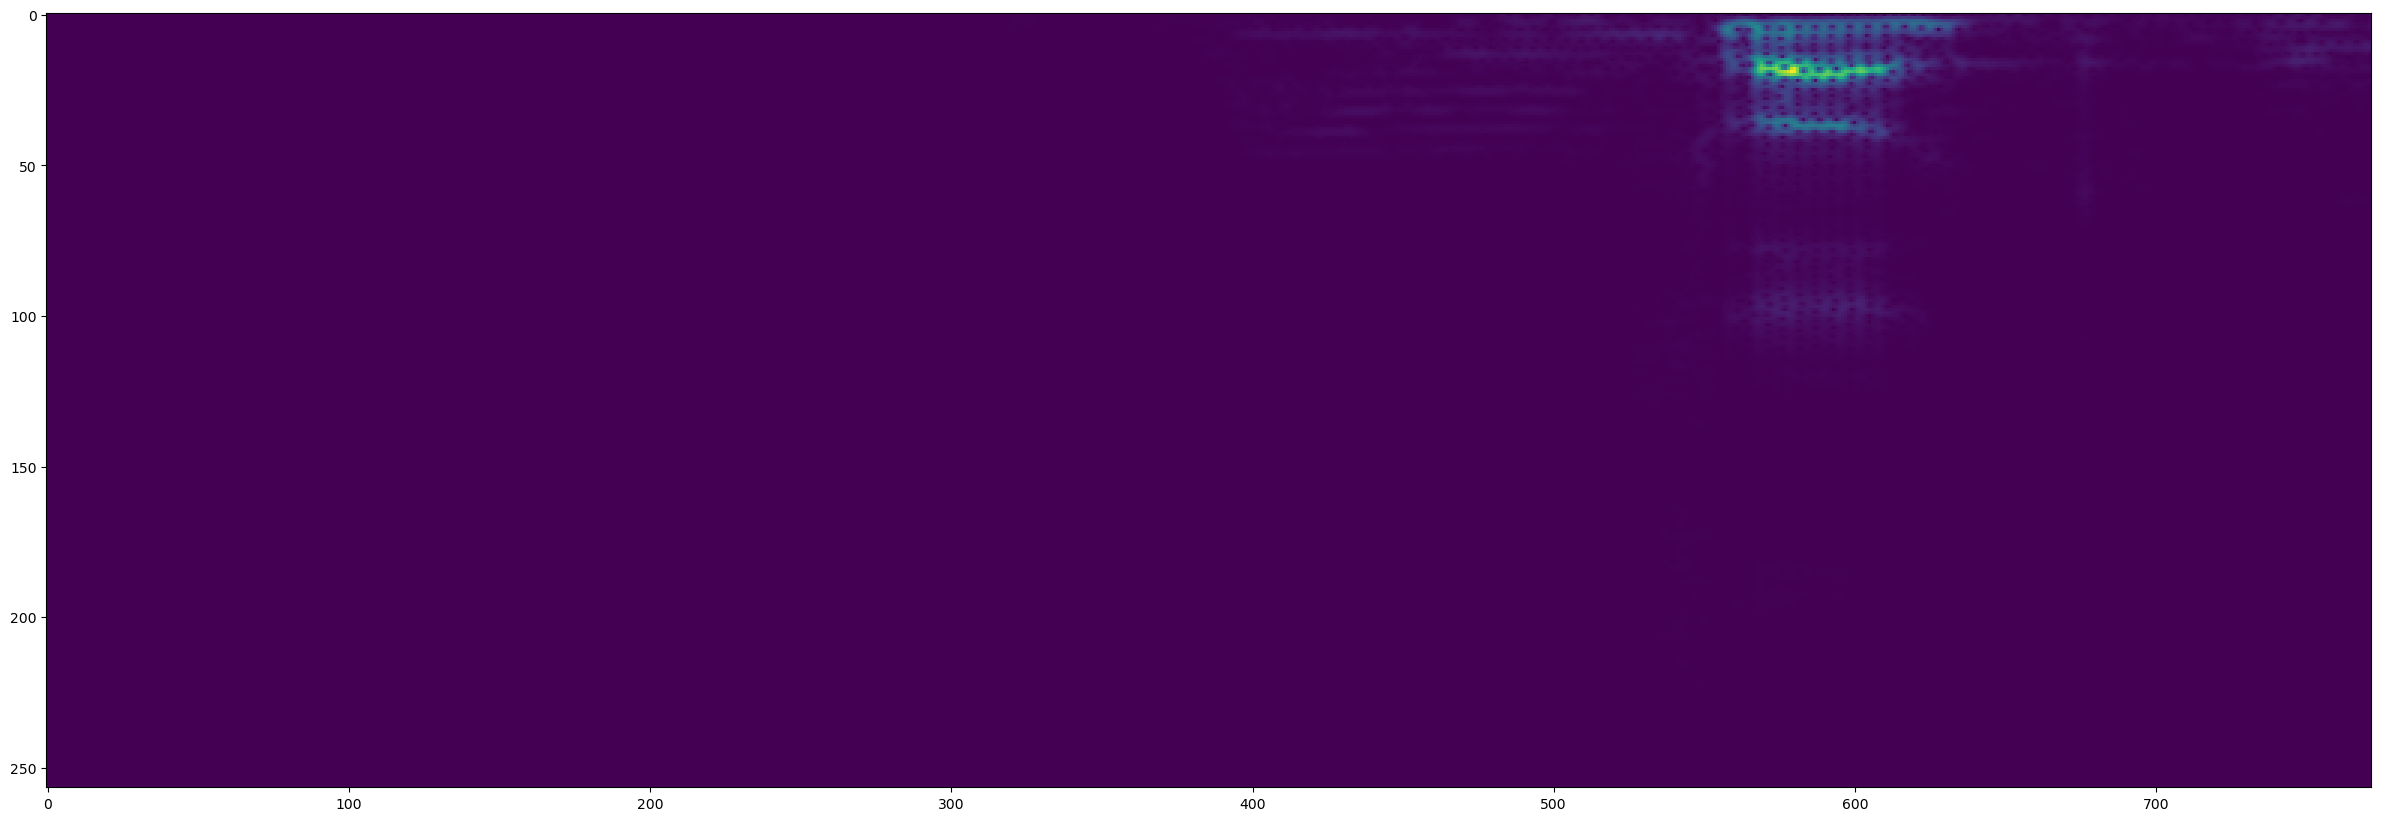

In [23]:
# test out the function and visualize the spectrogram (bad words)
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Create Training and Testing Partitions

In [24]:
len(data)

64

In [25]:
# create TensorFlow data pipeline
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(4)
data = data.prefetch(2)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [26]:
len(data)

16

In [27]:
# split into training and testing partitions
train = data.take(11)
test = data.skip(11).take(5)

In [28]:
# test one batch
samples, labels = train.as_numpy_iterator().next()

In [29]:
samples.shape

(4, 772, 257, 1)

In [30]:
labels

array([1., 1., 0., 1.], dtype=float32)

# Build Deep Learning Model

In [31]:
# load Keras Model dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard # to view statistics

# First Iteration Model

In [32]:
# build sequential model, compile, and view summary
'''
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(772, 257, 1))) # input shape depends on shape of our spec
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

# train the model
hist = model.fit(train, epochs=4, validation_data=test)
'''

# Training Various Configurations of Model

In [ ]:
# things we can test while training
# optimizer type
    # learning rate
# dense layers (whether we use them or we dont)
    # how many units per layer
    # which activation functions
    # kernel size
    # stride
    # decay/decay rate
    
# test various configs of model
dense_layers = [0, 1, 2] # 1 worked well so we check 1 and 2
layer_sizes = [8, 16, 32] # 16 worked well so we check 8 and 32
conv_layers = [1, 2, 3] # 2 worked well so we check 1 and 3
dense_sizes = [64, 128, 256] # 128 worked well so we check 64 and 256

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            for dense_size in dense_sizes:
                NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
                print(NAME)

                # create layers
                model = Sequential()
                model.add(Conv2D(layer_size, (3,3), input_shape=(772, 257, 1)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2)))

                for l in range(conv_layer-1):
                    model.add(Conv2D(layer_size, (3,3)))
                    model.add(Activation("relu"))
                    model.add(MaxPooling2D(pool_size=(2,2)))

                model.add(Flatten())
                for l in range(dense_layer):
                    model.add(Dense(dense_size)) # dense layers should be different sizes (not same as conv layer sizes)
                    model.add(Activation("relu"))

                # output layer
                model.add(Dense(1))
                model.add(Activation("sigmoid"))

                tensorboard = TensorBoard(log_dir='bad_mouth_logs/{}'.format(NAME))

                model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

                # tensorboard analysis
                hist = model.fit(train, epochs=4, validation_data=test, callbacks = [tensorboard])

# Fit Model, View Loss, and KPI Plots

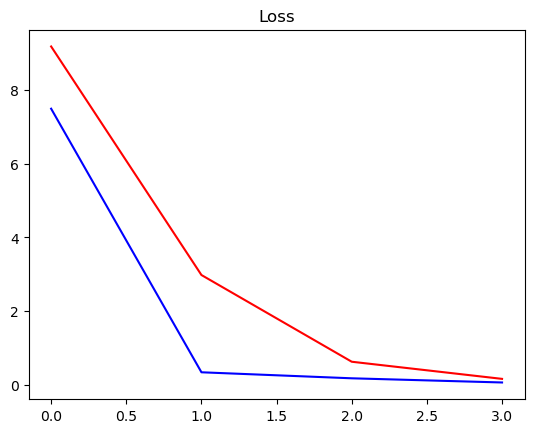

In [36]:
# plot loss 
# mean error across samples for each epoch (runthrough entire dataset)
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

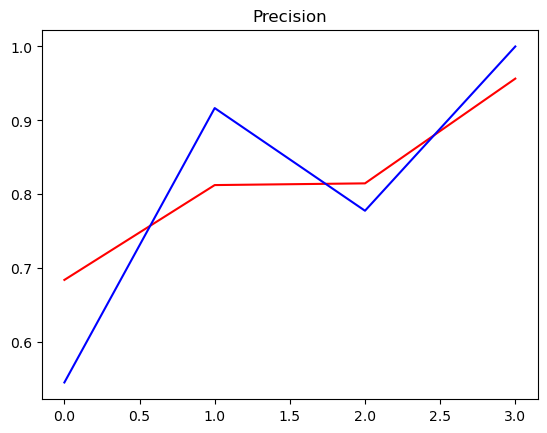

In [37]:
# plot precision
# the percent of positive predicitions that were correct (good and bad)
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

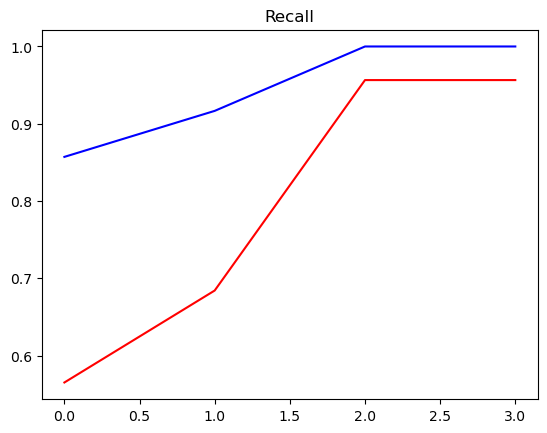

In [38]:
# plot recall
# the percentage of positive predicitions that were correct (only bad words)
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# Make a Prediction on a Single Clip

In [246]:
# get one batch and make a prediction
X_test, y_test = test.as_numpy_iterator().next()

In [247]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 102ms/step


In [248]:
yhat

array([[2.7421536e-04],
       [3.3446446e-09],
       [1.0574768e-02],
       [9.8515010e-01]], dtype=float32)

In [249]:
# Convert logits to classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [250]:
yhat

[0, 0, 0, 1]

In [251]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [252]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [253]:
y_test.astype(int)

array([0, 0, 0, 1])

# Save the Model

In [221]:
model.save('bad_mouth.model')
# load model
# new_model = tf.keras.models.load_model('num_reader.model')

INFO:tensorflow:Assets written to: bad_mouth.model\assets


INFO:tensorflow:Assets written to: bad_mouth.model\assets


# Convert to TF Lite

In [ ]:
TF_LITE_MODEL_FILE_NAME = "bad_mouth_lite.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\jreye\AppData\Local\Temp\tmprrod190b\assets


INFO:tensorflow:Assets written to: C:\Users\jreye\AppData\Local\Temp\tmprrod190b\assets


In [ ]:
# check input tensor shape
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")